In [1]:
import pandas as pd
import numpy as np
import umap
from plotly import graph_objects as go
from sklearn.cluster import KMeans
import shutil
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics

## 先對DATA進行簡單了解及清理

In [75]:
#Loading the dataset
df = pd.read_csv("marketing_campaign.csv", sep="\t")
print("Number of datapoints:", len(df))
df.head()

Number of datapoints: 2240


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

客戶基本資訊:'ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'Complain'  
客戶消費情況:'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds'  
客戶購物習慣:'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth'  
客戶是否接受推播:'NumDealsPurchases','AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Response'  
其他:'Z_CostContact', 'Z_Revenue'  
  
1.Income有缺失值  
2.Dt_Customer儲存形式非日期,可能需要轉換  
3.有類別變數需要進行轉換

In [77]:
#Dt_Customer進行轉換及簡單查看
df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"])
dates = []
for i in df["Dt_Customer"]:
    i = i.date()
    dates.append(i)  
#Dates of the newest and oldest recorded customer
print("最新的客戶:",max(dates))
print("最老的客戶:",min(dates))

最新的客戶: 2014-12-06
最老的客戶: 2012-01-08


In [78]:
#新增特徵"Customer_For"(註冊長度)
days = []
d1 = max(dates) #taking it to be the newest customer
for i in dates:
    delta = d1 - i
    days.append(delta)
df["Customer_For"] = days
df["Customer_For"] = pd.to_numeric(df["Customer_For"], errors="coerce")

In [79]:
print("Total categories in the feature Marital_Status:\n", df["Marital_Status"].value_counts(), "\n")
print("Total categories in the feature Education:\n", df["Education"].value_counts())

Total categories in the feature Marital_Status:
 Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64 

Total categories in the feature Education:
 Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: Education, dtype: int64


In [9]:
print("Total categories in the feature Z_CostContact:\n", df["Z_CostContact"].value_counts(), "\n")
print("Total categories in the feature Z_Revenue:\n", df["Z_Revenue"].value_counts())

Total categories in the feature Z_CostContact:
 3    2240
Name: Z_CostContact, dtype: int64 

Total categories in the feature Z_Revenue:
 11    2240
Name: Z_Revenue, dtype: int64


新增數項新特徵:
從"Year_Birth"中萃取"Age"  
加總所有消費為"Spent"  
"Living_With",將"Marital_Status"進行簡化為兩類"Partner"及"Alone"  
"Children",將"Kidhome"及"Teenhome"加總  
"Family_Size", 將家庭人數進行加總  
"Is_Parent", 判別是否為父母  
"Education"進行類別縮減

In [80]:
#Feature Engineering
#Age of customer today 
df["Age"] = 2021-df["Year_Birth"]

#Total spendings on various items
df["Spent"] = df["MntWines"]+ df["MntFruits"]+ df["MntMeatProducts"]+ df["MntFishProducts"]+ df["MntSweetProducts"]+ df["MntGoldProds"]

#Deriving living situation by marital status"Alone"
df["Living_With"]=df["Marital_Status"].replace({"Married":"Relationship", "Together":"Relationship", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})

#Feature indicating total children living in the household
df["Children"]=df["Kidhome"]+df["Teenhome"]

#Feature for total members in the householde
df["Family_Size"] = df["Living_With"].replace({"Alone": 1, "Relationship":2})+ df["Children"]

#Feature pertaining parenthood
df["Is_Parent"] = np.where(df.Children> 0, 1, 0)

#Segmenting education levels in three groups
df["Education"]=df["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Postgraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

#For clarity
df=df.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

#Dropping some of the redundant features
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth"]
df = df.drop(to_drop, axis=1)

In [81]:
#先對categorical features進行Label encoding
s = (df.dtypes == 'object')
object_cols = list(s[s].index)
print("Categorical variables in the dataset:", object_cols)

df["Education"]=df["Education"].replace({"Undergraduate":0, "Graduate":1, "Postgraduate":2})
df["Living_With"]=df["Living_With"].replace({"Alone":0, "Relationship":1})

Categorical variables in the dataset: ['Education', 'Living_With']


In [82]:
df.describe()

,ID,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,...,AcceptedCmp2,Complain,Response,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent
count,2240.000000,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,...,2240.000000,2240.000000,2240.000000,2.240000e+03,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,5592.159821,1.448661,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,...,0.013393,0.009375,0.149107,4.424054e+16,52.194196,605.798214,0.644643,0.950446,2.595089,0.715179
std,3246.662198,0.543793,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,...,0.114976,0.096391,0.356274,2.006466e+16,11.984069,602.249288,0.478728,0.751803,0.906959,0.451430
min,0.000000,0.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000e+00,25.000000,5.000000,0.000000,0.000000,1.000000,0.000000
25%,2828.250000,1.000000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,...,0.000000,0.000000,0.000000,2.944080e+16,44.000000,68.750000,0.000000,0.000000,2.000000,0.000000
50%,5458.500000,1.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,...,0.000000,0.000000,0.000000,4.432320e+16,51.000000,396.000000,1.000000,1.000000,3.000000,1.000000
75%,8427.750000,2.000000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,...,0.000000,0.000000,0.000000,5.920560e+16,62.000000,1045.500000,1.000000,1.000000,3.000000,1.000000
max,11191.000000,2.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,...,1.000000,1.000000,1.000000,9.184320e+16,128.000000,2525.000000,1.000000,3.000000,5.000000,1.000000


<AxesSubplot:>

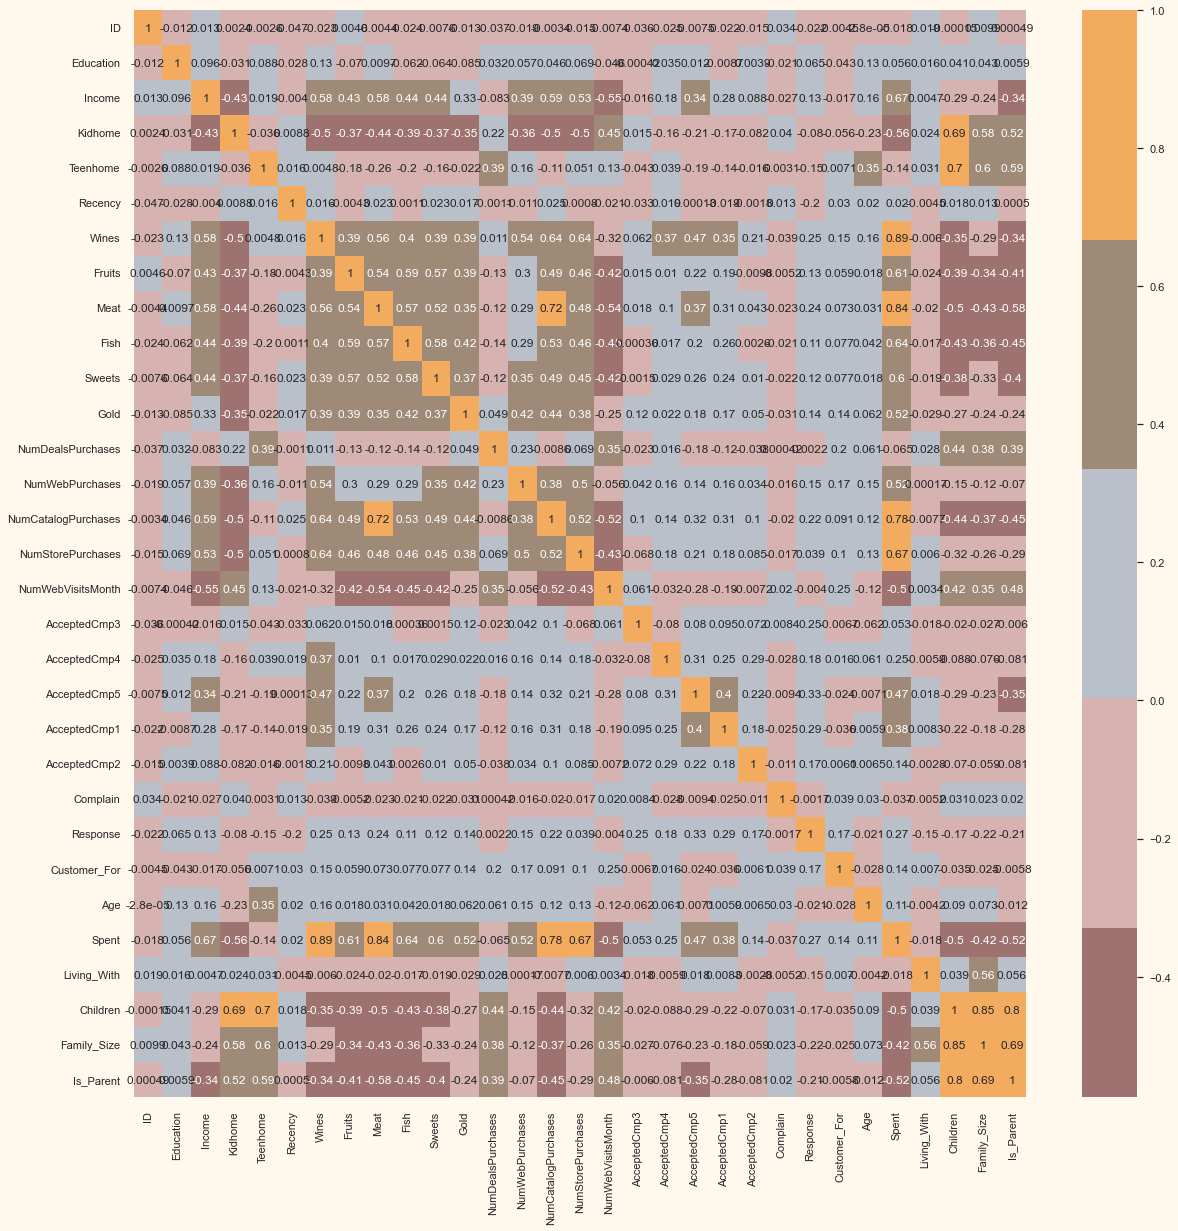

In [83]:
#correlation matrix
corrmat= df.corr()
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
plt.figure(figsize=(20,20))  
sns.heatmap(corrmat,annot=True, cmap=cmap, center=0)

可以看出部分特徵中存在outliers  
如age存在128yr,Income存在666666...  
針對幾項特徵進行觀察

Reletive Plot Of Some Selected Features: A Data Subset


<Figure size 576x396 with 0 Axes>

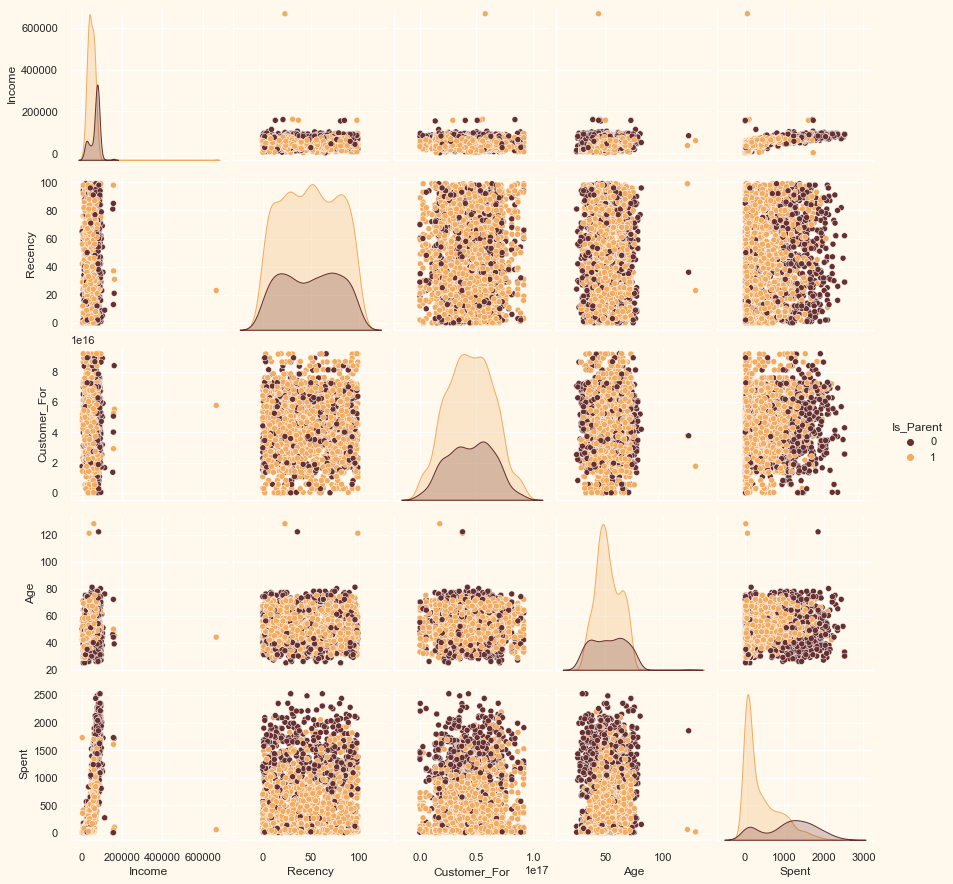

In [84]:
#To plot some selected features 
#Setting up colors prefrences
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
#Plotting following features
To_Plot = [ "Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]
print("Reletive Plot Of Some Selected Features: A Data Subset")
plt.figure()
sns.pairplot(df[To_Plot], hue= "Is_Parent",palette= (["#682F2F","#F3AB60"]))
#Taking hue 
plt.show()

In [101]:
#Dropping the outliers by setting a cap on Age and income. 
drop_list = list(np.concatenate([df[(df["Age"]>90)].index.values,df[(df["Income"]>600000)].index.values]))
df.drop(drop_list,inplace=True)
print("The total number of data-points after removing the outliers are:", len(df))

The total number of data-points after removing the outliers are: 2236


In [102]:
#Income與spent高度相關,建立兩者的線性模型迴歸進行補植
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm_df = df.dropna()
lm.fit(lm_df['Spent'].values.reshape(-1, 1),lm_df['Income'].values.reshape(-1, 1))

LinearRegression()

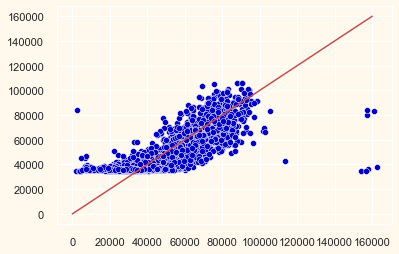

In [103]:
fig, ax = plt.subplots(figsize=(6, 4))
p1 = sns.scatterplot(x=lm_df["Income"].values,y=lm.predict(lm_df['Spent'].values.reshape(-1, 1)).reshape(lm_df["Income"].values.shape[0],),color = 'Mediumblue')
p2 = sns.lineplot(x=np.linspace(0, 160000, 160000), y=np.linspace(0, 160000, 160000), color='r', ax=ax)
plt.show()

In [114]:
fill_list = list(df[df["Income"].isna()].index.values)
for rows in fill_list:
    df.loc[rows,"Income"] = lm.predict(np.array(df.loc[rows,"Spent"]).reshape(1, -1))[0][0]

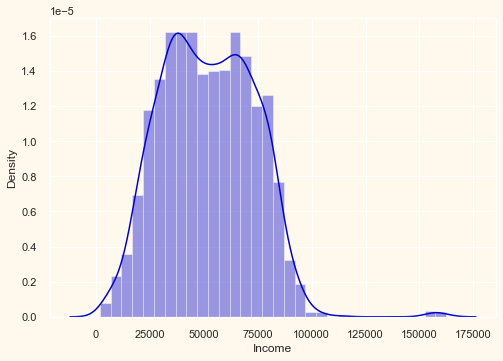

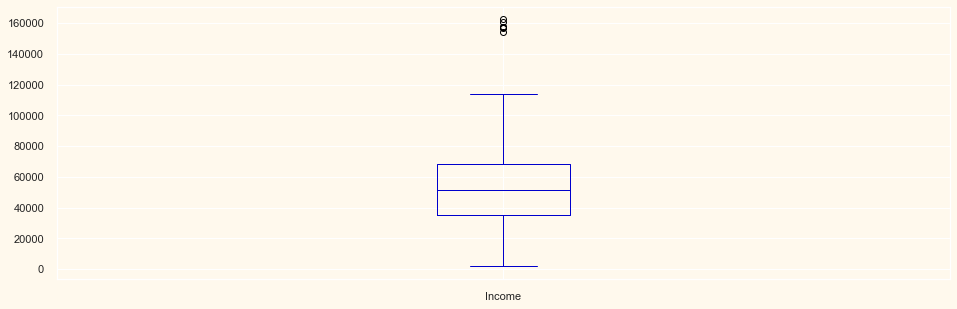

In [116]:
sns.distplot(df["Income"],color = 'Mediumblue')
plt.show()
df["Income"].plot.box(figsize=(16,5),color = 'MediumBlue')
plt.show()

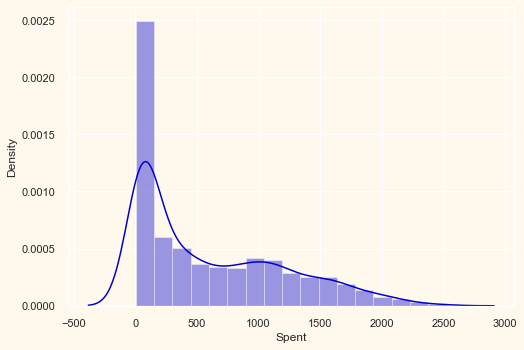

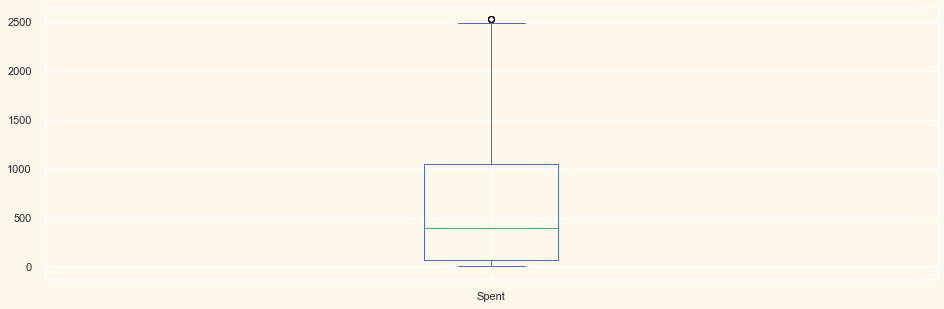

In [117]:
sns.distplot(df["Spent"],color = 'mediumblue')
plt.show()
df["Spent"].plot.box(figsize=(16,5))
plt.show()

## 資料前處理  
已完成feature encoding,尚需  
1.標準化  
2.降維

In [118]:
df.reset_index(drop=True, inplace=True)

In [119]:
#標準化
# creating a subset of dataframe by dropping the features on deals accepted and promotions
non_num_cols = ['ID','Education','Living_With','Is_Parent','AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
#Scaling
scaler = StandardScaler()
scaler.fit(df[[col for col in list(df.columns) if col not in non_num_cols]])
scaled_df = pd.DataFrame(scaler.transform(df[[col for col in list(df.columns) if col not in non_num_cols]]),columns= df[[col for col in list(df.columns) if col not in non_num_cols]].columns )
scaled_df = pd.merge(scaled_df,df[non_num_cols],left_index=True, right_index=True)

In [125]:
#多類別變數PCA前需one-hot encoding
scaled_df = scaled_df.join(pd.get_dummies(scaled_df.Education).rename(columns={0:'Education_Undergraduate',1:'Education_Graduate',2:'Education_Postgraduate'}))
scaled_df.drop(['Education','Education_Undergraduate'],axis=1,inplace=True)

In [128]:
scaled_df

,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,Is_Parent,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Education_Graduate,Education_Postgraduate
0,0.289565,-0.824939,-0.930615,0.306856,0.983228,1.554170,1.679746,2.461068,1.475396,0.845669,...,0,0,0,0,0,0,0,1,1,0
1,-0.259890,1.032627,0.905974,-0.383971,-0.871064,-0.636431,-0.713455,-0.650414,-0.631638,-0.729742,...,1,0,0,0,0,0,0,0,1,0
2,0.917334,-0.824939,-0.930615,-0.798467,0.362159,0.572177,-0.177201,1.344595,-0.147262,-0.038098,...,0,0,0,0,0,0,0,0,1,0
3,-1.177574,1.032627,-0.930615,-0.798467,-0.871064,-0.560893,-0.651409,-0.503991,-0.583200,-0.748954,...,1,0,0,0,0,0,0,0,1,0
4,0.296786,1.032627,-0.930615,1.550344,-0.389661,0.421101,-0.217088,0.154911,-0.001950,-0.556831,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2231,0.433288,-0.824939,0.905974,-0.107640,1.203128,0.421101,0.066551,0.081700,2.201960,3.900428,...,1,0,0,0,0,0,0,0,1,0
2232,0.563314,2.890194,0.905974,0.237773,0.302727,-0.661610,-0.607091,-0.687019,-0.655857,-0.691317,...,1,0,0,0,1,0,0,0,0,1
2233,0.235663,-0.824939,-0.930615,1.446720,1.794481,0.546997,0.221666,-0.101329,-0.365231,-0.383920,...,0,0,1,0,0,0,0,0,1,0
2234,0.807014,-0.824939,0.905974,-1.420212,0.368102,0.093769,0.208371,0.777208,0.070707,0.326936,...,1,0,0,0,0,0,0,0,0,1


## 進行分群  

In [129]:
scaled_df.drop('ID',axis=1,inplace=True)
#non_cols = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response']
#pca_df = scaled_df[[col for col in list(scaled_df.columns) if col not in non_cols]]
pca_df = scaled_df

In [130]:
#PCA
#Initiating PCA to reduce dimentions aka features to 3
pca = PCA(n_components=3)
reduced_df = pca.fit_transform(pca_df.iloc[:,:].values)

In [131]:
reduced_df

array([[ 4.75513311, -0.05102271,  2.50719243],
       [-2.86824796,  0.17891838, -2.27413281],
       [ 2.33699531, -0.72028218, -0.04980755],
       ...,
       [ 2.34760895, -1.64787312,  0.19850808],
       [ 1.71465418,  1.41884585, -1.70344728],
       [-2.58143458,  1.78096378, -0.17443033]])

In [132]:
labels = scaled_df.Response.values
fig = go.Figure(data=[go.Scatter3d(
    x=reduced_df[:,0],
    y=reduced_df[:,1],
    z=reduced_df[:,2],
    mode='markers',
    marker=dict(
        size=3,
        color=scaled_df.Response.values,
        opacity=0.8,
        line=dict(
            color='black',
            width=0
        )
    ),
    text=labels
)])

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

Elbow Method to determine the number of clusters to be formed:


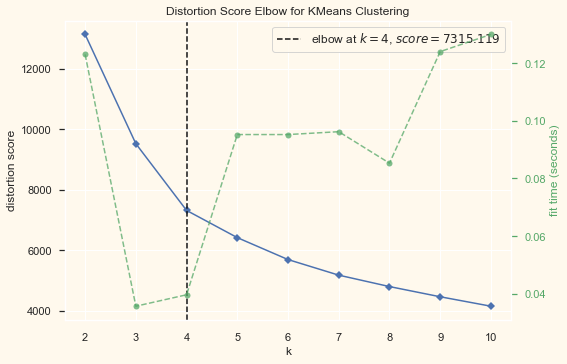

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [136]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(reduced_df)
Elbow_M.show()

In [133]:
#UMAP
dimension_reductor = umap.UMAP(n_components=3, n_neighbors=50, random_state=42)
reduced_df_umap = dimension_reductor.fit_transform(scaled_df.iloc[:,:].values)

In [134]:
reduced_df_umap

array([[ 6.3944426,  2.0731812,  6.1413083],
       [ 1.1391189, 11.976909 ,  4.666402 ],
       [ 5.5974326,  1.8284293,  5.8321733],
       ...,
       [ 5.7769513,  1.0590448,  5.9960256],
       [ 6.5720778,  6.993363 ,  2.7915943],
       [ 1.0827625, 11.302096 ,  3.8348227]], dtype=float32)

In [135]:
labels = scaled_df.Response.values
fig = go.Figure(data=[go.Scatter3d(
    x=reduced_df_umap[:,0],
    y=reduced_df_umap[:,1],
    z=reduced_df_umap[:,2],
    mode='markers',
    marker=dict(
        size=3,
        color=scaled_df.Response.values,
        opacity=0.8,
        line=dict(
            color='black',
            width=0
        )
    ),
    text=labels
)])

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

從UMAP結果中可以看出明顯的分為4群  
利用分群法將這四群分出來

In [137]:
#使用k-means嘗試分類
cls = KMeans(n_clusters=4, init = 'k-means++')
cls_ids = cls.fit_predict(reduced_df_umap)

In [139]:
labels = cls_ids
fig = go.Figure(data=[go.Scatter3d(
    x=reduced_df_umap[:,0],
    y=reduced_df_umap[:,1],
    z=reduced_df_umap[:,2],
    mode='markers',
    marker=dict(
        size=3,
        color=np.array(['red', 'blue', 'green','yellow'])[cls_ids],
        opacity=0.8,
        line=dict(
            color='black',
            width=0
        )
    ),
    text=labels
)])

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

In [146]:
cluster = pd.Series(cls_ids)
cluster.name = 'clusters'
scaled_df = scaled_df.join(cluster)

In [148]:
#先將分群結果存檔
scaled_df.to_csv('output.csv',index=False)

## 檢查此分群結果下的差別